<a href="https://colab.research.google.com/github/Tom-Hammond/AI-Neural-Network-Coding/blob/main/AssignmentCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Data and display word cloud

<function matplotlib.pyplot.show(*args, **kw)>

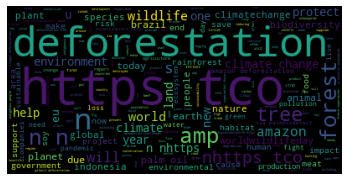

In [45]:
import pandas as pd 

data = pd.read_csv('deforestation_sentiment_train.csv',usecols=["text","revised_sentiment"], na_values = ['no info', '.'])

text = data['text'].values
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show

Clean data ready for processing

In [46]:
import re

num_classes = 2

def process_sentence(sentence):
    '''Removes all special characters from sentence. It will also strip out
    extra whitespace and makes the string lowercase.
    '''
    return re.sub(r'[\\\\/:*«`\'?¿";!<>,.|]', '', sentence.lower().strip())


# Clean the sentences
X = data["text"].apply(process_sentence)[:500]
y = data["revised_sentiment"][:500]
print('YYYYYYY',y)

# Split all our sentences
elements = (' '.join([sentence for sentence in X])).split()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
print(len(X_train), len(X_test))
len(X_train), len(X_test)
labels = set(y)

print("Feature Shapes:")
print("\tTrain set: \t\t{}".format(X_train.shape),
      "\n\tTest set: \t\t{}".format(X_test.shape))
print("Totals:\n\tWords in our Dataset: {}\n\tLabels: {}".format(len(elements), 
len(labels)))

# Lets look at our training data
print(X_train[:10], y_train[:10])

YYYYYYY 0      negative
1      negative
2      negative
3      negative
4      negative
         ...   
495    negative
496    negative
497    negative
498    negative
499    negative
Name: revised_sentiment, Length: 500, dtype: object
400 100
Feature Shapes:
	Train set: 		(400,) 
	Test set: 		(100,)
Totals:
	Words in our Dataset: 16243
	Labels: 1
249    we need to protect tropical forests from defor...
433    soy used as animal feed for🐄🐓🐖 in our food sup...
19     @ghgguru @cynfab3 @ltdsgn @ourcowmolly @oatlyu...
322    im really liking this old school tractor cant ...
332    were speaking at the @ulula4good #webinar next...
56     these beautiful animals are extinct from pakis...
301    here’s 5 reasons we should fight to protect ou...
229    deforestation soars in amazon forest in 2020 a...
331    these photos shows trees damaged by deforestat...
132    near real-time forest deforestation monitoring...
Name: text, dtype: object 249    negative
433    negative
19     negative
322   

Refine processed data

In [47]:
def create_lookup_tables(text):
    """Create lookup tables for vocabulary
    :param text: The text split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab = set(text)
    
    vocab_to_int = {word: i for i, word in enumerate(vocab)}
    int_to_vocab = {v:k for k, v in vocab_to_int.items()}
    
    return vocab_to_int, int_to_vocab

elements.append("<UNK>")

# Map our vocabulary to int
vocab_to_int, int_to_vocab = create_lookup_tables(elements)
labels_to_int, int_to_labels = create_lookup_tables(y)
#print("Vocabulary of our dataset: {}".format(len(vocab_to_int)))

def convert_to_int(data, data_int):
    """Converts all our text to integers
    :param data: The text to be converted
    :return: All sentences in ints
    """
    all_items = []
    for sentence in data: 
        all_items.append([data_int[word] if word in data_int else data_int["<UNK>"]
for word in sentence.split()])
    
    return all_items

 # Convert our inputs
X_test_encoded = convert_to_int(X_test, vocab_to_int)
X_train_encoded = convert_to_int(X_train, vocab_to_int)
y_data = convert_to_int(y_test, labels_to_int)  

Encoding/Embedding

In [48]:
from sklearn.preprocessing import OneHotEncoder



enc = OneHotEncoder()
enc.fit(y_data)
# One hot encoding our outputs
y_train_encoded = enc.fit_transform(convert_to_int(y_train, 
labels_to_int)).toarray()
y_test_encoded = enc.fit_transform(convert_to_int(y_test, labels_to_int)).toarray()
# Sample of our encoding
print(y_train_encoded[:10],'\n', y_train[:10])

import numpy as np

embeddings_index = {}

#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip
path_to_glove_file = 'glove.6B.100d.txt'

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(set(elements)) + 2
embedding_dim = 100
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocab_to_int.items():
    embedding_vector = 100 #embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"

        
       
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
 249    negative
433    negative
19     negative
322    negative
332    negative
56     negative
301    negative
229    negative
331    negative
132    negative
Name: revised_sentiment, dtype: object
Found 400000 word vectors.
Converted 5210 words (0 misses)


Training and using Model

In [49]:
import tensorflow as tf
# Import Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding
from keras.preprocessing import sequence

# Hyperparameters
max_sentence_length = 350
embedding_vector_length = 400
dropout = 0.7

import numpy

# Truncate and pad input sentences
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_encoded, 
maxlen=max_sentence_length)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_encoded, 
maxlen=max_sentence_length)
# Create the model
model = Sequential()
    
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

model.add(embedding_layer)
model.add(GRU(256, return_sequences=True, dropout=dropout, 
recurrent_dropout=dropout))
model.add(GRU(256, dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(len(labels), activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='adam', 
metrics=['accuracy'])
    
print(model.summary())
# Train the model
model.fit(X_train_pad, y_train_encoded, batch_size=32, epochs=5, 
validation_data=(X_test_pad, y_test_encoded))
# Final evaluation of the model
scores = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

def predict_sentence(sentence):
    """Converts the text and sends it to the model for classification
    :param sentence: The text to predict
    :return: string - The label of the sentence
    """
    
    # Clean the sentence
    sentence = process_sentence(sentence)
    
    # Transform and pad it before using the model to predict
    x = numpy.array(convert_to_int([sentence], vocab_to_int))
    x = sequence.pad_sequences(x, maxlen=max_sentence_length)
    
    prediction = model.predict(x)
    
    # Get the highest prediction
    lang_index = numpy.argmax(prediction)
    
    return int_to_labels[lang_index]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         521200    
                                                                 
 gru_4 (GRU)                 (None, None, 256)         274944    
                                                                 
 gru_5 (GRU)                 (None, 256)               394752    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,191,153
Trainable params: 669,953
Non-trainable params: 521,200
_________________________________________________________________
None
Epoch 1/5
13/13 [==============================] - 91s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
13/13 [===

Plotting as a learning curve

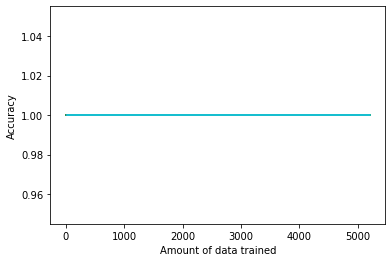

In [50]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import mnist_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

xpoints = X_test.all

plt.plot(X_test_pad, y_test_encoded)
plt.xlabel("Amount of data trained")
plt.ylabel("Accuracy")
plt.show()